## Model Training

In [1]:
import os
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#### Dataset Class for Preparation

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, audio_dir, video_dir, text_dir): # Constructor 
        
        # All the Directories with Extracted Features as .npy
        self.audio_dir = audio_dir 
        self.video_dir = video_dir
        self.text_dir  = text_dir

        # Including only the files in the directory
        audio_files = set(os.listdir(audio_dir))
        video_files = set(os.listdir(video_dir))
        text_files  = set(os.listdir(text_dir))

        # File Alignment for all the files with audio,video and text
        self.files = sorted(audio_files & video_files & text_files)

    def __len__(self): # Length Function
        return len(self.files)

    def __getitem__(self, idx): # Get Index Extraction
        fname = self.files[idx]

        audio_path = os.path.join(self.audio_dir, fname)
        video_path = os.path.join(self.video_dir, fname)
        text_path  = os.path.join(self.text_dir,  fname)

        # Loading only the existing files with all three features 
        if not (os.path.exists(audio_path) and os.path.exists(video_path) and os.path.exists(text_path)):
            raise IndexError(f"Missing modality file for {fname}")

        audio = np.load(audio_path)
        video = np.load(video_path)
        text  = np.load(text_path)

        # Converting the .npy to Tensors with Pooling if required
        
        # Temporal Mean Pooling for audio to match Tensor Dimensions 
        audio = torch.tensor(audio, dtype=torch.float32).mean(dim=1)

        # Temporal Mean Pooling for video to match Tensor Dimensions 
        video = torch.tensor(video, dtype=torch.float32)
        
        if video.ndim == 3:
            video = video.mean(dim=0).mean(dim=0)  
        elif video.ndim == 2:
            video = video.mean(dim=0)            
        else:
            raise ValueError(f"Unexpected video shape: {video.shape}")

        text = torch.tensor(text, dtype=torch.float32)

        # Labelling the File as Truth or Lie 
        label = 1 if "lie" in fname else 0
        label = torch.tensor(label, dtype=torch.long)
        
        # Returning the Audio,Video,Text Tensors and Label
        return audio, video, text, label


#### Creating the Feature Fusion Model 

In [ ]:
import torch.nn as nn

class FeatureFusionModel(nn.Module):
    def __init__(self, audio_dim, video_dim, text_dim):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(audio_dim + video_dim + text_dim, 256), # Input is concatenation of all the dimensions  
            nn.ReLU(), # Relu Function with Input -> 256 Neurons 
            nn.Dropout(0.3), # Dropout of 30% for better model generalisation 
            nn.Linear(256, 2) # Two outputs Lie/Truth 
        )

    def forward(self, audio, video, text): # Forward Pass \
        
        # Flattening the tensors with different shapees 
    
        audio = audio.view(audio.size(0), -1) 
        video = video.view(video.size(0), -1)

        x = torch.cat([audio, video, text], dim=1) # Concatinating all the features 
        return self.fc(x)

#### Preparation of Training and Testing Data

In [ ]:
training_data = MultimodalDataset(
    audio_dir="features/audio/train",
    video_dir="features/video/train",
    text_dir="features/text/train"
)

test_data = MultimodalDataset(
    audio_dir="features/audio/test",
    video_dir="features/video/test",
    text_dir="features/text/test"
)

Aligned samples loaded: 100
Aligned samples loaded: 10


#### Using Data Loader for Batch Splits and Shuffle

In [ ]:
train_loader =DataLoader(
    training_data,
    batch_size=8, 
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False
)

#### Training Intialisations

In [ ]:
a, v, t, _ = training_data[0] # Fetching the Dimensions 

audio_dim = a.numel()
video_dim = v.numel()
text_dim  = t.numel()

In [ ]:
device="mps" # Using MPS for faster training 

In [ ]:
model=FeatureFusionModel(audio_dim,video_dim,text_dim).to(device) # Moving to MPS 
 
criterion = nn.CrossEntropyLoss() # Using Cross Entropy Loss as Binary Classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # Using Adam Optimizer with 1e-4 as learning rate

#### Epoch wise Training 

In [ ]:
def train_one_epoch(model, loader):
    
    model.train() # Moving the Model to Training state 
    total_loss, correct, total = 0, 0, 0 # Loss, Classified and Misclassified Count 

    for audio, video, text, labels in tqdm(loader): # Iterating through features from loader
        audio, video, text, labels = (
            # Moving to the MPS 
            audio.to(device),
            video.to(device),
            text.to(device),
            labels.to(device)
        )

        optimizer.zero_grad() # Clearing the Residual Gradients 
        outputs = model(audio, video, text) # Computing the Output from Forward Pass 
        loss = criterion(outputs, labels) # Computing BCE Loss 
        loss.backward() # Computing the Gradients 
        optimizer.step() # Updating the Weights 

        total_loss += loss.item() # Computing the Total Loss 
        
        preds = outputs.argmax(dim=1) # Flattening the Prediction from Forward Pass
        correct += (preds == labels).sum().item() # Totalling up the Correctly Classified ones
        total += labels.size(0) # Computing Total Classes 

    return total_loss / len(loader), correct / total # Loss Epoch wise and accuracy


#### Epoch Wise Evaluation

In [ ]:
def evaluate(model, loader):
    model.eval() # Changing the Model State to Evaluation
    correct, total = 0, 0 # Correct and Total 

    with torch.no_grad(): # Disabling the Gradient Computation 
        
        for audio, video, text, labels in loader: # Iterating through Loader Objects 
            audio, video, text, labels = (
                # Moving the Objects to MPS
                audio.to(device),
                video.to(device),
                text.to(device),
                labels.to(device)
            )

            outputs = model(audio, video, text) # Computing Output using Forward Pass
            preds = outputs.argmax(dim=1) # Flattening Outputs 
            correct += (preds == labels).sum().item() # Summing up Correct Classifications 
            total += labels.size(0) # Totalling the Classes 

    return correct / total # Accuracy Correctly Classified / Total Classes 


#### Starting the Training 

In [ ]:
train_losses = [] # Loss every epoch 
train_accuracies = [] # Accuracy / epoch 
test_accuracies = []

EPOCHS = 15 # Total Epochs 

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader) # Computing Train Loss and Accuracy 
    test_acc = evaluate(model, test_loader) # Model Evaluation 

    train_losses.append(train_loss) # Appending the Training Loss for Visualisation 
    train_accuracies.append(train_acc) # Appending the Training Accuracies for Visualisation 
    test_accuracies.append(test_acc) # Appending the Testing Accuracies for Visualisation 
 
    # Displaying the needed metadata
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Test Acc: {test_acc:.4f}"
    )

100%|██████████| 13/13 [00:00<00:00, 46.83it/s]


Epoch 1/15 | Loss: 0.4005 | Train Acc: 0.8800 | Test Acc: 0.7000


100%|██████████| 13/13 [00:00<00:00, 145.60it/s]


Epoch 2/15 | Loss: 0.3846 | Train Acc: 0.8900 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 134.18it/s]


Epoch 3/15 | Loss: 0.3743 | Train Acc: 0.9100 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 149.09it/s]


Epoch 4/15 | Loss: 0.3404 | Train Acc: 0.8900 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 80.31it/s]


Epoch 5/15 | Loss: 0.3357 | Train Acc: 0.9100 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 144.13it/s]


Epoch 6/15 | Loss: 0.3114 | Train Acc: 0.9300 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 127.84it/s]


Epoch 7/15 | Loss: 0.3070 | Train Acc: 0.9400 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 142.05it/s]


Epoch 8/15 | Loss: 0.2900 | Train Acc: 0.9600 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 128.84it/s]


Epoch 9/15 | Loss: 0.2848 | Train Acc: 0.9700 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 114.72it/s]


Epoch 10/15 | Loss: 0.2606 | Train Acc: 0.9700 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 117.78it/s]


Epoch 11/15 | Loss: 0.2347 | Train Acc: 0.9700 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 123.46it/s]


Epoch 12/15 | Loss: 0.2621 | Train Acc: 0.9600 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 136.33it/s]


Epoch 13/15 | Loss: 0.2359 | Train Acc: 0.9900 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 132.96it/s]


Epoch 14/15 | Loss: 0.2312 | Train Acc: 0.9900 | Test Acc: 0.8000


100%|██████████| 13/13 [00:00<00:00, 117.83it/s]

Epoch 15/15 | Loss: 0.2165 | Train Acc: 0.9900 | Test Acc: 0.8000


#### Training and Testing Accuracy Epoch Wise 

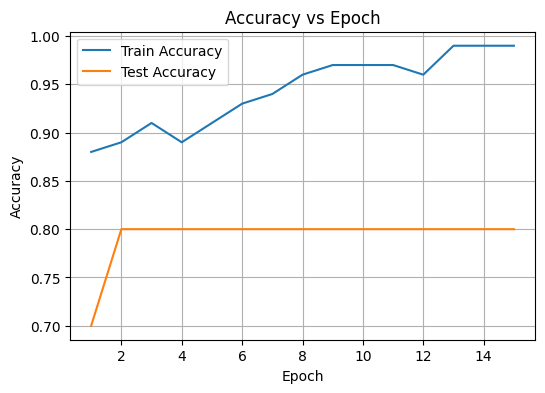

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

#### Loss Values Epoch Wise

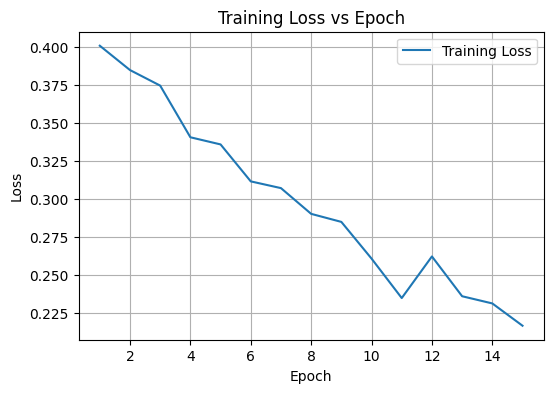

In [15]:
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


#### Plotting the Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for audio, video, text, labels in test_loader:
        audio, video, text = audio.to(device), video.to(device), text.to(device)
        outputs = model(audio, video, text)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())


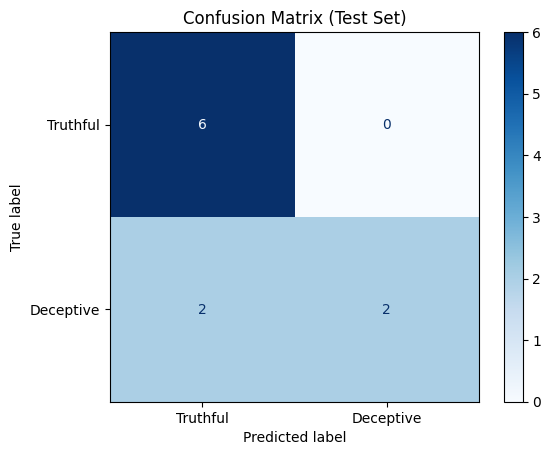

In [17]:
cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Truthful", "Deceptive"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()
